In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from scipy.stats import norm
import matplotlib.pyplot as plt
device = torch.device("cuda:0" if torch.cuda.is_available() else 'cpu')
from sklearn.preprocessing import StandardScaler
from ts_rnn import Model, Optimization, generate_sequence, to_dataframe, inverse_transform, transform_data
%matplotlib inline

In [ ]:
# NOTE: import our RNN modules
from bayesian_rnn import BRNN
from dropout_rnn import DRNN # Arka, feel free to change these names

=================== air ===================
Epoch 1 Train loss: 0.84. Validation loss: 1.09. Avg future: 24.02. Elapsed time: 7.70s.
Epoch 2 Train loss: 0.49. Validation loss: 0.55. Avg future: 26.86. Elapsed time: 12.64s.
Epoch 3 Train loss: 0.31. Validation loss: 0.31. Avg future: 26.83. Elapsed time: 10.61s.
Epoch 4 Train loss: 0.22. Validation loss: 0.25. Avg future: 23.01. Elapsed time: 12.05s.
Epoch 5 Train loss: 0.20. Validation loss: 0.24. Avg future: 25.54. Elapsed time: 12.05s.
Epoch 6 Train loss: 0.19. Validation loss: 0.23. Avg future: 25.46. Elapsed time: 13.90s.
Epoch 7 Train loss: 0.19. Validation loss: 0.23. Avg future: 25.67. Elapsed time: 13.24s.
Epoch 8 Train loss: 0.19. Validation loss: 0.23. Avg future: 26.63. Elapsed time: 11.82s.
Epoch 9 Train loss: 0.18. Validation loss: 0.23. Avg future: 26.74. Elapsed time: 14.01s.
Epoch 10 Train loss: 0.19. Validation loss: 0.23. Avg future: 25.65. Elapsed time: 12.90s.
Epoch 11 Train loss: 0.18. Validation loss: 0.23. Avg fu

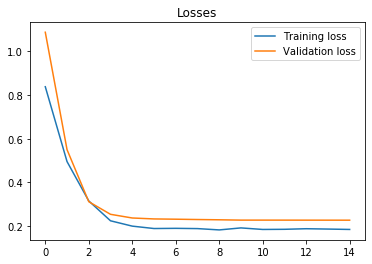

<Figure size 432x288 with 0 Axes>

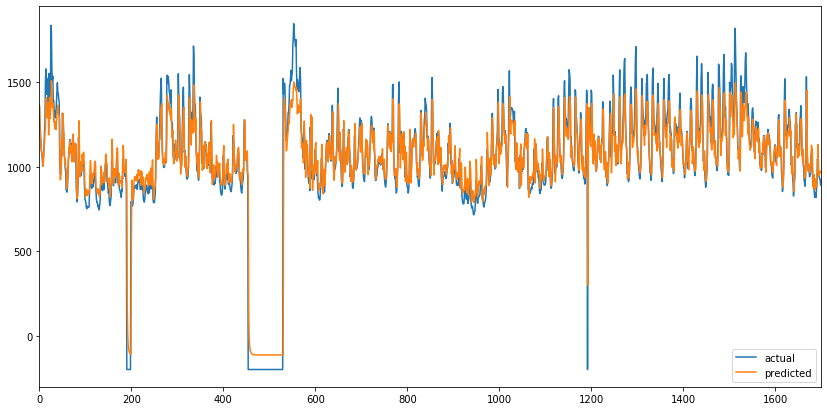

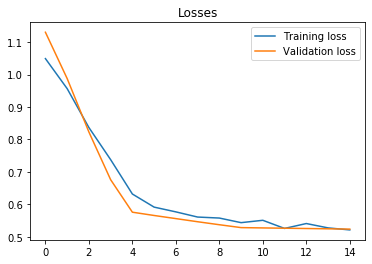

<Figure size 432x288 with 0 Axes>

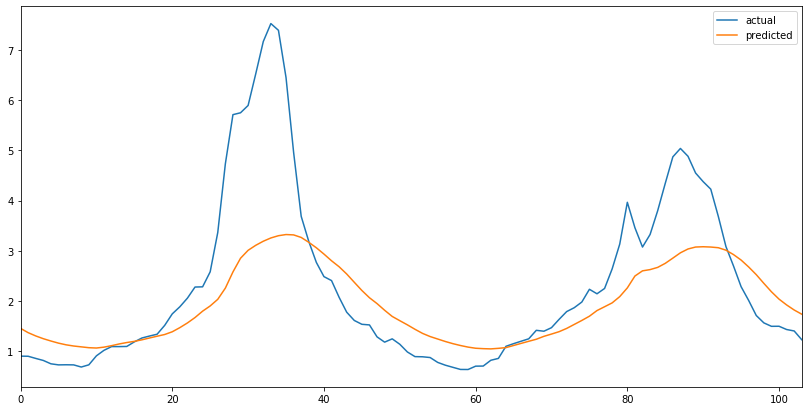

In [21]:
# import datasets
air = pd.read_csv('data/AirQualityUCI.csv', sep=';', skip_blank_lines=True, keep_default_na=True)
# finance = pd.read_csv('data_akbilgic.csv')
flu = pd.read_csv('data/NationalILINet.csv')
# rnn_data, rnn_label_wILI = load_flu_data(length, first_year,region)

# for air, index 3 is PT08.S1(CO)
# for flu, index 4 is weighted ILI
for name, df, col_idx, seq_len in zip(['air','flu'],[air, flu], [3, 4], [100, 52]):
    
    print('=================================================')
    print('===================',name, '===================')
    df.dropna(how='all', inplace=True)
    train_end_idx, val_end_idx = int(df.shape[0]*0.6), int(df.shape[0]*0.8)
    df_train = df.iloc[:train_end_idx, col_idx].to_frame(name='train')  
    df_val = df.iloc[train_end_idx:val_end_idx, col_idx].to_frame(name='val')  
    df_test = df.iloc[val_end_idx:, col_idx].to_frame(name='test')  

    # data scaling
    scaler = StandardScaler()
    train_arr = scaler.fit_transform(df_train)
    val_arr = scaler.transform(df_val)
    test_arr = scaler.transform(df_test)

    x_train, y_train = transform_data(train_arr, seq_len)
    x_val, y_val = transform_data(val_arr, seq_len)
    x_test, y_test = transform_data(test_arr, seq_len)

    # take a look, it's the same sequence but shifted 1
#     print(x_train[0,:10])
#     print(y_train[0,:10])

    # NOTE: change rnn with ours, e.g. rnn=BRNN
    model_1 = Model(input_size=1, hidden_size=21, output_size=1, rnn=nn.LSTMCell).to(device)
    loss_fn_1 = nn.MSELoss()
    optimizer_1 = optim.Adam(model_1.parameters(), lr=1e-3)
    scheduler_1 = optim.lr_scheduler.StepLR(optimizer_1, step_size=5, gamma=0.1)
    optimization_1 = Optimization(model_1, loss_fn_1, optimizer_1, scheduler_1)
    # train with teacher forcing
    optimization_1.train(x_train, y_train, x_val, y_val, do_teacher_forcing=True, batch_size=32)
    # plot loss
    plt.figure()
    optimization_1.plot_losses()
    
    # evaluation
    actual_1, predicted_1, test_loss_1 = optimization_1.evaluate(x_test, y_test, future=1, batch_size=seq_len)
    df_result_1 = to_dataframe(actual_1, predicted_1) 
    df_result_1 = inverse_transform(scaler, df_result_1, ['actual', 'predicted'])
    plt.figure()
    df_result_1.plot(figsize=(14, 7))
    print("Test loss %.4f" % test_loss_1)

In [ ]:
# TODO: adapt this code to previous code which shows confidence intervals
# this part was taken from repo shared by Arka

# here we predict and get uncertainty
# we should design the experiment

samples = 100
x_tmp = torch.linspace(-100,100,1000).reshape(-1,1).to(device)
y_samp = np.zeros((samples,1000))
for s in range(samples):
    y_tmp = net(x_tmp).cpu().detach().numpy()
    y_samp[s] = y_tmp.reshape(-1)
plt.plot(x_tmp.cpu().numpy(), np.mean(y_samp, axis = 0), label='Mean Posterior Predictive')
plt.fill_between(x_tmp.cpu().numpy().reshape(-1), np.percentile(y_samp, 2.5, axis = 0), np.percentile(y_samp, 97.5, axis = 0), alpha = 0.25, label='95% Confidence')
plt.legend()
plt.scatter(x, toy_function(x))
plt.title('Posterior Predictive')
plt.show()